In [23]:
import torch
import torch.nn as nn
import numpy as np
import os
import sys
sys.path.append("./src/models/")
sys.path.append("./src/")
import utils as utils
from torch.utils.data import DataLoader
from MWU_CNN import MW_Unet
from tqdm import tqdm
import torchvision
import matplotlib.pyplot as plt

In [30]:
def imshow(img):
    print('Image device and mean')
    print(img.device)
    print(img.mean())
    output_image = img.cpu().numpy().transpose((1,2,0))
    npimg = np.interp(output_image,(-1.0,1.0),(0,255.0)).astype(np.uint8)
    print('Mean of image: {}'.format(npimg.mean()))
    #format H,W,C
    plt.imshow(npimg)
    plt.show()
def save_image(img, path):
#     img = img * 0.5 + 0.5
    torchvision.utils.save_image(img, path)
    
def backprop(optimizer,model_output,target):
    optimizer.zero_grad()
    loss_fn = nn.MSELoss()
    loss = loss_fn(model_output,target)
    loss.backward()
    optimizer.step()
    return loss
def get_PSNR(model_output,target):
    I_hat = model_output.cpu().detach().numpy()
    I = target.cpu().detach().numpy()
    mse = (np.square(I-I_hat)).mean(axis=None)
    PSNR = 10 * np.log10(1.0/mse)
    return PSNR
def train(args):
    """
    train model
    """
    
    ####################################### Initializing Model #######################################
    
    step = 0.01
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print_every = int(args['--print_every'])
    num_epochs = int(args['--num_epochs'])
    save_every = int(args['--save_every'])
    save_path = str(args['--model_save_path'])
    batch_size = int(args['--batch_size'])
    train_data_path = args['--data_path']
    n  = int(args['--n'])
    train_split,val_split = args['--train_split'],args['--val_split']
    
    img_directory = args['--train_img_directory']

    model = MW_Unet(num_conv=3,in_ch=1)
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(),lr=step)
    
    ######################################### Loading Data ##########################################
    dataset_total = utils.patchesDataset(patches_path=train_data_path,n=n)
    
    train_max_idx = int(train_split*len(dataset_total))
#     print(train_max_idx)
    dataset_train = torch.utils.data.Subset(dataset_total,range(0,train_max_idx))
    val_max_idx = train_max_idx+int(val_split*len(dataset_total))
    dataset_val = torch.utils.data.Subset(dataset_total,range(train_max_idx,val_max_idx))
#     print(test_max_idx)
    
#     dataset_test = torch.utils.data.Subset(dataset_total,range(val_max_idx,test_max_idx))
    
    dataloader_train = DataLoader(dataset_train,batch_size=batch_size)
    dataloader_val = DataLoader(dataset_val,batch_size=batch_size)
    
    
    print("length of train set: ",len(dataset_train))
    print("length of val set: ",len(dataset_val))
#     print("length of test set: ",len(dataset_test))
    
    train_PSNRs = []
    train_losses = []
    val_PSNRs = []
    val_losses = []
    init_epoch = 0 
    
    best_val_PSNR = 0.0
    try:
        for epoch in range(1, num_epochs + 1):
                #INITIATE dataloader_train
                print("epoch: ",epoch)
                with tqdm(total = len(dataloader_train)) as pbar:
                    for index, sample in enumerate(dataloader_train):

                        model.train()

                        target,model_input = sample['target'],sample['input']
                        target = target.to(device)
                        model_input = model_input.to(device)

                        output = model.forward(model_input)

                        train_loss = backprop(optimizer,output,target)

                        train_PSNR = get_PSNR(output,target)

                        avg_val_PSNR = []
                        avg_val_loss = []
                        model.eval()
                        with torch.no_grad():
                            for val_index,sample in enumerate(dataloader_val):
                                target,model_input = sample['target'],sample['input']
                                
                                target = target.to(device)
                                model_input = model_input.to(device)
                                
                                output = model.forward(model_input)
                                loss_fn = nn.MSELoss()
                                loss_val = loss_fn(output,target)
                                PSNR = get_PSNR(output,target)
                                avg_val_PSNR.append(PSNR)
                                avg_val_loss.append(loss_val.cpu().detach().numpy())
                        avg_val_PSNR = np.mean(avg_val_PSNR)
                        avg_val_loss = np.mean(avg_val_loss)
                        val_PSNRs.append(avg_val_PSNR)
                        val_losses.append(avg_val_loss)

                        train_losses.append(train_loss.cpu().detach().numpy())
                        train_PSNRs.append(train_PSNR)

                        if index == len(dataloader_train) - 1:
                            img_grid = output.data
                            img_grid = torchvision.utils.make_grid(img_grid)
                            directory = img_directory
                            save_image(img_grid,'{}train_img_{}.png'.format(directory,epoch))
                            print('train images')
                            imshow(img_grid)
                            
                        pbar.update(1)
                    if epoch % print_every == 0: 
                        print ("Epoch: {}, Loss: {}, Training PSNR: {}".format(epoch, train_loss, train_PSNR))
                        print ("Epoch: {}, Avg Val Loss: {},Avg Val PSNR: {}".format(epoch, avg_val_loss, avg_val_PSNR))
                    if epoch % save_every == 0 and best_val_PSNR < avg_val_PSNR:
                        best_val_PSNR = avg_val_PSNR
                        print("new best Avg Val PSNR: {}".format(best_val_PSNR))
                        print ("Saving model to {}".format(save_path))
                        torch.save({'epoch': epoch,
                            'model_state_dict': model.state_dict(), 
                            'optimizer_state_dict': optimizer.state_dict(), 
                            'loss': train_loss}, 
                             save_path)
                        print ("Saved successfully to {}".format(save_path))
                        
                        
    except KeyboardInterrupt:
        print("Training interupted...")
        print ("Saving model to {}".format(save_path))
        torch.save({'epoch': epoch,
                    'model_state_dict': model.state_dict(), 
                    'optimizer_state_dict': optimizer.state_dict(), 
                    'loss': train_loss}, 
                     save_path)
        print ("Saved successfully to {}".format(save_path))          
        

    print("Training completed.")
    
    return (train_losses,train_PSNRs,val_losses,val_PSNRs,best_val_PSNR)

def Test(args):
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print_every = int(args['--print_every'])
    num_epochs = int(args['--num_epochs'])
    save_every = int(args['--save_every'])
    batch_size = int(args['--batch_size'])
    n  = int(args['--n'])
    train_split,val_split,test_split = args['--train_split'],args['--val_split'],args['--test_split']
    data_path = args['--data_path']
    model_path = args['--model_save_path']
    img_directory = args['--test_img_directory']
    ################################ Load Data ###################################################
    dataset_total = utils.patchesDataset(patches_path=data_path,n=n)
    train_max_idx = int(train_split*len(dataset_total))
    val_max_idx = train_max_idx+int(val_split*len(dataset_total))
    test_max_idx = val_max_idx + int(test_split*len(dataset_total))
    dataset_test = torch.utils.data.Subset(dataset_total,range(val_max_idx,test_max_idx))
    dataloader_test = DataLoader(dataset_test, batch_size = batch_size)
    
#     print(len(dataset_test))
    load_path = model_path
    
    model = MW_Unet(num_conv=3,in_ch=1)
    model.to(device)
    
    if(load_path != None):
        print("Loading model from {}".format(load_path))
        checkpoint = torch.load(load_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        #optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        #epoch = checkpoint['epoch']
        print("Model successfully loaded from {}".format(load_path))
    
    model.eval()
    
    print("Testing...")
    
    test_loss = []
    test_PSNR = []
    
    with tqdm(total=len(dataloader_test)) as pbar:
        with torch.no_grad():
            for index, sample in enumerate(dataloader_test):
                target,model_input = sample['target'],sample['input']
                target = target.to(device)
                model_input = model_input.to(device)

                output = model.forward(model_input)
                
                loss_fn = nn.MSELoss()

                loss = loss_fn(output,target)
                PSNR = get_PSNR(output,target)
                
                test_loss.append(loss.cpu().numpy())
                test_PSNR.append(PSNR)
                
                if index == len(dataloader_test) - 1:
                    img_grid = output.data
                    img_grid = torchvision.utils.make_grid(img_grid)
                    directory = img_directory
                    save_image(img_grid,'{}test_img.png'.format(directory))
                    print('test images')
                    imshow(img_grid)
                pbar.update(1)
                
                
    test_loss,test_PSNR = np.mean(np.array(test_loss)), np.mean(np.array(test_PSNR))
    
    str_to_save = "Test_loss: " + str(test_loss) + " , Test PSNR: " + str(test_PSNR)
    
    with open("test_results.txt",'a') as test_writer:
        test_writer.write(str_to_save + "\n")
    
    return (test_loss,test_PSNR)


            
        
            

                    
                            
                            
                            
                            
                    
                    
                    

    
    
    
    


  0%|          | 0/2000 [00:00<?, ?it/s]

channel_1: 16, channel_2: 32
loading patches from patches directory


  0%|          | 0/25 [00:00<?, ?it/s]

completed loading patches from directory!
(2000, 240, 240)
shape of target: (2000, 1, 240, 240) shape of noisy: (2000, 1, 240, 240)
length of train set:  1600
length of val set:  200
epoch:  1


 96%|█████████▌| 24/25 [00:18<00:00,  1.26it/s]

train images
Image device and mean
cuda:0
tensor(138.6729, device='cuda:0')
Mean of image: 253.36613713647668


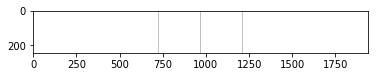

  0%|          | 0/25 [00:00<?, ?it/s]

new best Avg Val PSNR: 14.940141660485905
Saving model to ./experiments/baseline/baseline.pt
Saved successfully to ./experiments/baseline/baseline.pt
epoch:  2


 96%|█████████▌| 24/25 [00:18<00:00,  1.32it/s]

train images
Image device and mean
cuda:0
tensor(126.8211, device='cuda:0')
Mean of image: 253.36613713647668


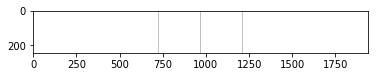

  0%|          | 0/25 [00:00<?, ?it/s]

new best Avg Val PSNR: 18.355592971843734
Saving model to ./experiments/baseline/baseline.pt
Saved successfully to ./experiments/baseline/baseline.pt
epoch:  3


 96%|█████████▌| 24/25 [00:18<00:00,  1.32it/s]

train images
Image device and mean
cuda:0
tensor(123.3186, device='cuda:0')
Mean of image: 253.36613713647668


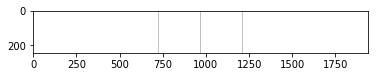

  0%|          | 0/25 [00:00<?, ?it/s]

new best Avg Val PSNR: 20.51637476745227
Saving model to ./experiments/baseline/baseline.pt
Saved successfully to ./experiments/baseline/baseline.pt
epoch:  4


 52%|█████▏    | 13/25 [00:09<00:09,  1.29it/s]


Training interupted...
Saving model to ./experiments/baseline/baseline.pt
Saved successfully to ./experiments/baseline/baseline.pt
Training completed.
Final training loss: 0.009517055936157703, Best Validation PSNR: 20.51637476745227
loading patches from patches directory


  0%|          | 0/4 [00:00<?, ?it/s]

completed loading patches from directory!
(2000, 240, 240)
shape of target: (2000, 1, 240, 240) shape of noisy: (2000, 1, 240, 240)
channel_1: 16, channel_2: 32
Loading model from ./experiments/baseline/baseline.pt
Model successfully loaded from ./experiments/baseline/baseline.pt
Testing...


 75%|███████▌  | 3/4 [00:00<00:00,  6.99it/s]

test images
Image device and mean
cuda:0
tensor(134.8218, device='cuda:0')
Mean of image: 253.36613713647668


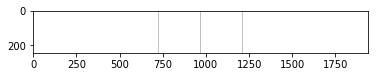

100%|██████████| 4/4 [00:00<00:00,  6.21it/s]

Test loss: 0.011239456944167614, Test PSNR: 19.499345130184764


In [31]:
args = {'--print_every':5,
        '--num_epochs':10,
        '--save_every':1,
        '--data_path':'./data/patches/',
        '--batch_size':64,
        '--model_save_path': "./experiments/baseline/baseline.pt",
        '--n': 2000,
        '--test_split': 0.1,
        '--val_split':0.1,
        '--train_split':0.8,
        '--train_img_directory':'./experiments/images/train_images/',
        '--test_img_directory': './experiments/images/test_images/'
        }
train_losses,train_PSNRs,val_losses,val_PSNRs,best_val_PSNR = train(args)
np.save('train_PSNRs.npy', np.array(train_PSNRs))
np.save('train_losses.npy', np.array(train_losses))
np.save('val_PSNRs.npy', np.array(val_PSNRs))
np.save('val_losses.npy', np.array(val_losses))

loss = train_losses[-1]
print("Final training loss: {}, Best Validation PSNR: {}".format(loss, best_val_PSNR))

test_loss,test_PSNR = Test(args)
print("Test loss: {}, Test PSNR: {}".format(test_loss, test_PSNR))